안정성 점수 만드는 코드

In [13]:
pip install cliffs-delta

Note: you may need to restart the kernel to use updated packages.


# 라이브러리 호출

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from cliffs_delta import cliffs_delta
from scipy.stats import mannwhitneyu, shapiro

가설검정 컬럼 데이터 분포 확인 -> 이상치제거 -> 데이터 분포 재확인(정규분포인지 시각적으로 대략 판단, 이상시 log or boxcox변환) 
-> 성장그룹별 표본수 1000개 샘플링-> 시각화로 성장여부 그룹별 차이 확인 -> 성장여부 그룹별 정규성 검정 
-> 거의 대부분 정규성 만족 x 이기 때문에 비모수통계검정(만휘트니 (샘플링ver, 전체 ver 비교)) 
-> 검정통계 p-value와 cliff's delta 값으로 변수 유의미 여부 판단

# 안정성 점수 생성 및 검증

## 표준화 => PCA(주성분2개) => 민맥스 -사용 변수 6개, 로그 변환-

In [5]:
# 파일 경로
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192.csv"

# 데이터 불러오기
df = pd.read_csv(file_path, encoding="utf-8")

# 2024년 2분기 데이터 필터링
df = df[df['연분기'] == 20242]

# 사용할 특성(변수) 목록
features = ['프랜차이즈_변동성', '개폐업_균형_지수', '매출_금액_변동성', '매출_건수_변동성', '3년생존률', '5년생존률']

# 데이터 타입 변환 (숫자로 변환, 변환 불가능한 값은 NaN 처리)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# 상권별 평균값 계산
df_selected = df[['상권명'] + features].groupby('상권명')[features].mean().reset_index()

# 결측치(NaN) 처리: 중앙값으로 대체
df_selected[features] = df_selected[features].fillna(df_selected[features].median())

# 표준화 (Z-score 변환)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])

# PCA 수행 (주성분 2개 선택)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
explained_variance = pca.explained_variance_ratio_

# 주성분 가중 평균 계산
weighted_pca_score = (pca_result[:, 0] * explained_variance[0]) + (pca_result[:, 1] * explained_variance[1])
weighted_pca_score = weighted_pca_score.reshape(-1, 1)

# Min-Max 스케일링 (0~20 범위)
minmax_scaler = MinMaxScaler(feature_range=(0, 20))
final_scores = minmax_scaler.fit_transform(weighted_pca_score)

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권명': df_selected['상권명'],
    '안정성_점수': final_scores.flatten()
})

# 안정성 점수 기준 내림차순 정렬
result_df = result_df.sort_values('안정성_점수', ascending=False)

# 출력
print(result_df)

              상권명     안정성_점수
914          신논현역  20.000000
1381          코엑스  17.049400
1236          잠실역  16.181581
36    강남 마이스 관광특구  15.220791
192         구의사거리  15.030908
...           ...        ...
1468       화계역 2번   0.448300
1094    영등포본동주민센터   0.445956
1441       헌인가구단지   0.296900
966     신월3동 골목시장   0.272437
631    북한산보국문역 1번   0.000000

[1502 rows x 2 columns]


### 분포 히스토그램

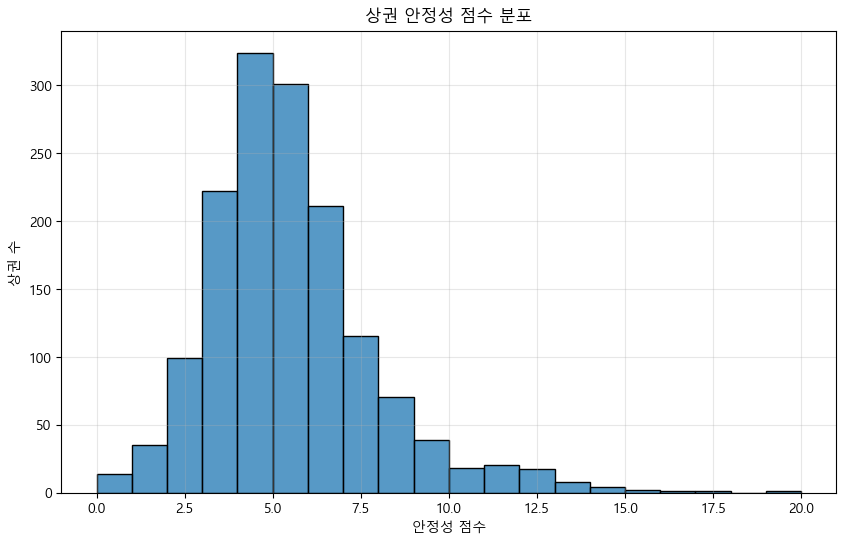

In [6]:
# 히스토그램 생성
plt.figure(figsize=(10, 6))
sns.histplot(data=result_df, x='안정성_점수', bins=20)

# 그래프 제목과 축 레이블 설정
plt.title('상권 안정성 점수 분포')
plt.xlabel('안정성 점수')
plt.ylabel('상권 수')

# 그리드 추가
plt.grid(True, alpha=0.3)

plt.show()

### 분산 비율 확인

In [7]:
# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")

주성분 1: 설명된 분산 비율 = 0.2874
주성분 2: 설명된 분산 비율 = 0.1976


### 주성분과의 상관관계 분석

🔍 주성분과 원래 변수 간의 상관관계:
                PC1       PC2
프랜차이즈_변동성  0.693717 -0.045951
개폐업_균형_지수 -0.023307 -0.457865
매출_금액_변동성  0.755396  0.096067
매출_건수_변동성  0.814301 -0.020235
3년생존률      0.039952  0.675615
5년생존률     -0.086846  0.712500


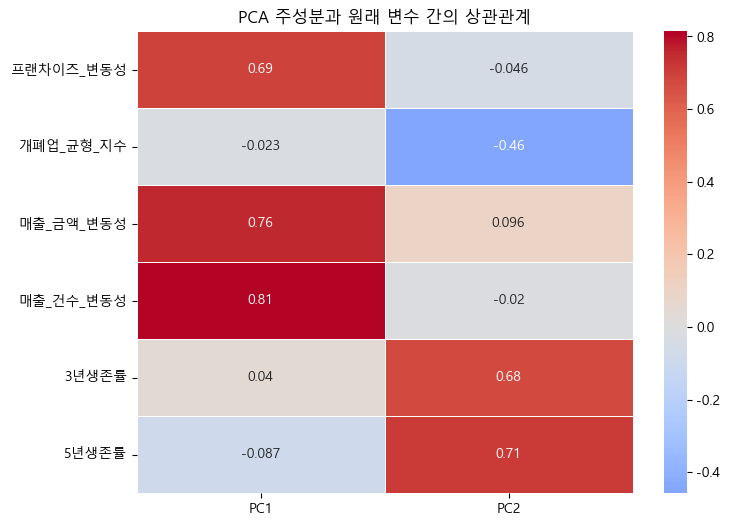

In [8]:
# 파일 경로
file_path = r"C:\Users\m\Desktop\변수 생성용 데이터\매출변수_20192.csv"

# 데이터 불러오기
df = pd.read_csv(file_path, encoding="utf-8")

# 2024년 2분기 데이터 필터링
df = df[df['연분기'] == 20242]

# 사용할 특성(변수) 목록
features = ['프랜차이즈_변동성', '개폐업_균형_지수', '매출_금액_변동성', '매출_건수_변동성', '3년생존률', '5년생존률']

# 데이터 타입 변환 (숫자로 변환, 변환 불가능한 값은 NaN 처리)
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# 상권별 평균값 계산
df_selected = df[['상권명'] + features].groupby('상권명')[features].mean().reset_index()

# 결측치(NaN) 처리: 중앙값으로 대체
df_selected[features] = df_selected[features].fillna(df_selected[features].median())

# 표준화 (Z-score 변환)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])

# PCA 수행 (주성분 2개 선택)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# 원래 데이터와 주성분 간의 상관관계 계산
correlation_matrix_pc1 = pd.DataFrame(scaled_features, columns=features).corrwith(pca_df['PC1'])
correlation_matrix_pc2 = pd.DataFrame(scaled_features, columns=features).corrwith(pca_df['PC2'])

# 상관관계 결과 합치기
correlation_df = pd.DataFrame({
    'PC1': correlation_matrix_pc1,
    'PC2': correlation_matrix_pc2
})

# 결과 출력
print("🔍 주성분과 원래 변수 간의 상관관계:")
print(correlation_df)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("PCA 주성분과 원래 변수 간의 상관관계")
plt.show()

### 안정성 점수 확인

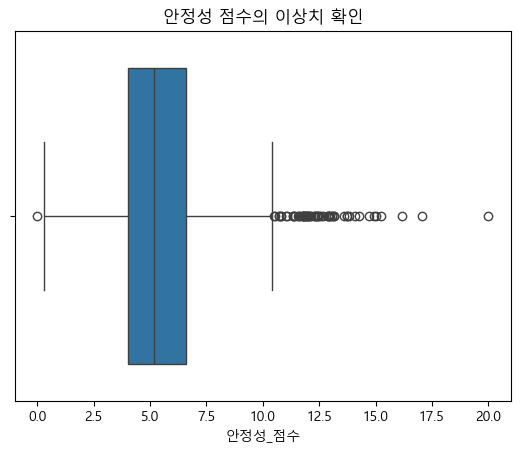

In [9]:
sns.boxplot(x=result_df['안정성_점수'])
plt.title("안정성 점수의 이상치 확인")
plt.show()

### 실제 데이터와의 일관성 확인

In [10]:
# 안정성 점수와 폐업률 간의 상관관계 계산
real_data = df_selected[['상권명', '3년생존률']]  # 실제 생존률 데이터
merged_df = result_df.merge(real_data, on='상권명')

correlation = merged_df['안정성_점수'].corr(merged_df['3년생존률'])
print("안정성 점수와 실제 생존률 간의 상관계수:", correlation)

안정성 점수와 실제 생존률 간의 상관계수: 0.369238882327566


### 안정성 점수 분포 비율 확인

In [11]:
# 안정성 기준 설정 (상위 35%를 안정으로 분류)
threshold = result_df['안정성_점수'].quantile(0.65)  # 65% 지점(하위 65%)

# 안정(35%) / 불안정(65%) 분류
result_df['분류'] = result_df['안정성_점수'].apply(lambda x: '안정' if x >= threshold else '불안정')

# 실제 분포 확인
print(result_df['분류'].value_counts(normalize=True))

분류
불안정    0.6498
안정     0.3502
Name: proportion, dtype: float64
